<a href="https://colab.research.google.com/github/ConorD28/NFL-Data-Bowl/blob/main/NFL_Big_Data_Bowl%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load in Data**

In [ ]:
!pip install scikit-learn==1.4.2 #need this version for XG Boost tuning to work
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
%matplotlib inline
!pip install dask distributed

In [ ]:
plays = pd.read_csv("plays.csv")
NA_percents = round(plays.isnull().sum()/len(plays) * 100, 1)
NA_percents2 = pd.DataFrame(data = NA_percents.values, index = NA_percents.index, columns = ["NA Percents"])
NA_percents2.sort_values("NA Percents", ascending = False)

,NA Percents
penaltyYards,97.6
timeToSack,96.2
pff_runConceptSecondary,82.5
qbSneak,57.9
rushLocationType,57.9
targetY,48.1
targetX,48.1
timeToThrow,46.0
passLength,45.9
timeInTackleBox,44.7


In [ ]:
plays2 = plays.dropna(axis = 1, how = "any") #drop columns with NAs
plays2["offenseFormation"] = plays["offenseFormation"] #add offense Formation column
plays2.dropna(inplace = True) #drop rows with NAs

# **EDA**

In [ ]:
plays["offenseFormation"].value_counts()

,count
offenseFormation,
SHOTGUN,8791
SINGLEBACK,3915
EMPTY,1342
I_FORM,1035
PISTOL,641
JUMBO,125
WILDCAT,87


In [ ]:
plays["rushLocationType"].value_counts()

,count
rushLocationType,
INSIDE_RIGHT,1941
INSIDE_LEFT,1929
OUTSIDE_RIGHT,1470
OUTSIDE_LEFT,1283
UNKNOWN,165


In [ ]:
Shotgun = plays[plays["offenseFormation"] == "SHOTGUN"]
Empty = plays[plays["offenseFormation"] == "EMPTY"]
Singleback = plays[plays["offenseFormation"] == "SINGLEBACK"]
I_Form = plays[plays["offenseFormation"] == "I_FORM"]
Pistol = plays[plays["offenseFormation"] == "PISTOL"]

Yards Gained by Formation Box Plots:

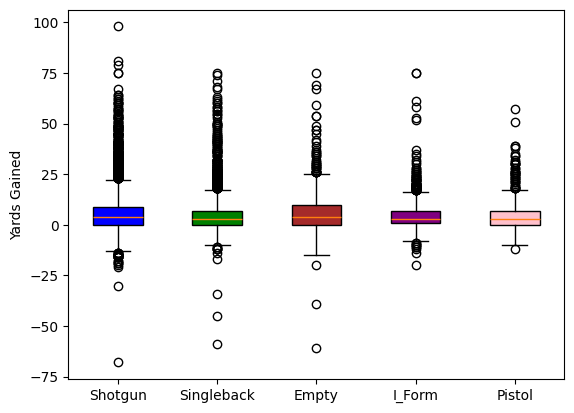

In [ ]:
fig, ax = plt.subplots()
ax.set_ylabel('Yards Gained')
labels = ["Shotgun", "Singleback", "Empty", "I_Form", "Pistol"]

my_dict = {'Shotgun': Shotgun["yardsGained"].values, 'Singleback': Singleback["yardsGained"].values,
           'Empty': Empty["yardsGained"].values, 'I_Form': I_Form["yardsGained"].values,
           'Pistol': Pistol["yardsGained"].values}

bplot = ax.boxplot(my_dict.values(), patch_artist=True)
ax.set_xticklabels(labels)

colors = ['blue', 'green', 'brown', 'purple', 'pink']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

In [ ]:
print("Median Yards Gained by Formation:")
print(f'SHOTGUN: {np.median(Shotgun["yardsGained"])}')
print(f'EMPTY: {np.median(Empty["yardsGained"])}')
print(f'SINGLEBACK: {np.median(Singleback["yardsGained"])}')
print(f'I_FORM: {np.median(I_Form["yardsGained"])}')
print(f'PISTOL: {np.median(Pistol["yardsGained"])}')

Median Yards Gained by Formation:
SHOTGUN: 4.0
EMPTY: 4.0
SINGLEBACK: 3.0
I_FORM: 3.0
PISTOL: 3.0


In [ ]:
playsSubset = plays[~plays["rushLocationType"].isin(["UNKNOWN"])] #rids QB Kneels

Pass = playsSubset[~playsSubset["rushLocationType"].isin(["INSIDE_RIGHT",
                                                                    "INSIDE_LEFT",
                                                                    "OUTSIDE_RIGHT",
                                                                    "OUTSIDE_LEFT"])] #includes sacks and does not include scrambles, a scramble could be a QB designed run
Run = playsSubset[playsSubset["rushLocationType"].isin(["INSIDE_RIGHT",
                                                                    "INSIDE_LEFT",
                                                                    "OUTSIDE_RIGHT",
                                                                    "OUTSIDE_LEFT"])]
Run = Run[Run.passResult != "R"] #drop scrambles

Yards Gained by Pass vs Run Box Plots:

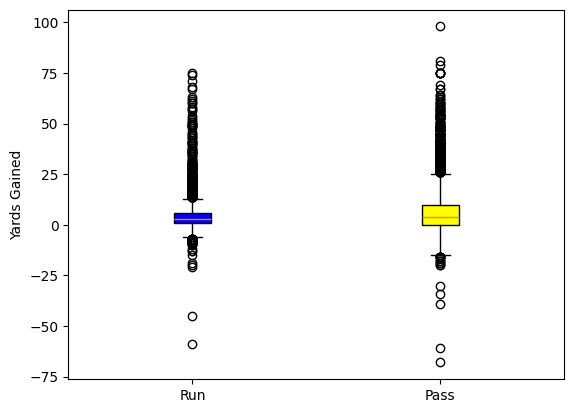

In [ ]:
fig, ax = plt.subplots()
ax.set_ylabel('Yards Gained')
labels = ["Run", "Pass"]

my_dict = {'Run': Run["yardsGained"].values, 'Complete': Pass["yardsGained"].values}

bplot = ax.boxplot(my_dict.values(), patch_artist=True)
ax.set_xticklabels(labels)

colors = ['blue', 'yellow']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

In [ ]:
print("Median Yards Gained:")
print(f'Pass: {np.median(Pass["yardsGained"])}')
print(f'Run: {np.median(Run["yardsGained"])}')

Median Yards Gained:
Pass: 4.0
Run: 3.0


Formation By Pass or Run:

In [ ]:
ShotgunPass = Pass[Pass["offenseFormation"] == "SHOTGUN"]
ShotgunRun = Run[Run["offenseFormation"] == "SHOTGUN"]
EmptyPass = Pass[Pass["offenseFormation"] == "EMPTY"]
EmptyRun = Run[Run["offenseFormation"] == "EMPTY"]
SinglebackPass= Pass[Pass["offenseFormation"] == "SINGLEBACK"]
SinglebackRun = Run[Run["offenseFormation"] == "SINGLEBACK"]
I_FormPass = Pass[Pass["offenseFormation"] == "I_FORM"]
I_FormRun = Run[Run["offenseFormation"] == "I_FORM"]
PistolPass = Pass[Pass["offenseFormation"] == "PISTOL"]
PistolRun = Run[Run["offenseFormation"] == "PISTOL"]

In [ ]:
len(EmptyRun) #only 47 rows so exclude from box plots and medians

47

Yards Gained by Formation and Play Type Box Plots:

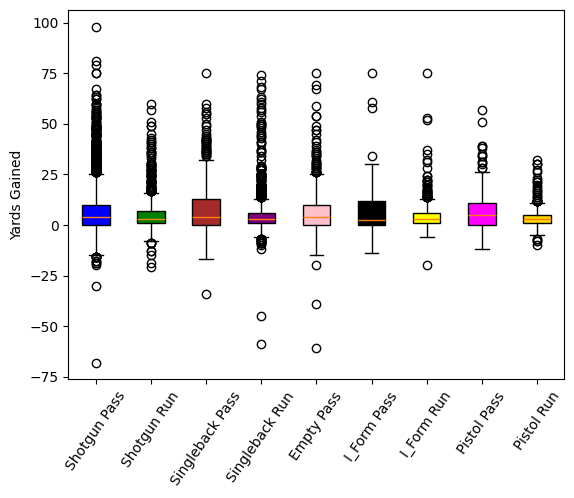

<Figure size 2000x1000 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()
ax.set_ylabel('Yards Gained')
labels = ["Shotgun Pass", 'Shotgun Run', "Singleback Pass", "Singleback Run", "Empty Pass",
          "I_Form Pass", "I_Form Run", "Pistol Pass", "Pistol Run"]

my_dict = {'Shotgun Pass': ShotgunPass["yardsGained"].values, 'Shotgun Run': ShotgunRun["yardsGained"].values,
           'Singleback Pass': SinglebackPass["yardsGained"].values, 'Singleback Run': SinglebackRun["yardsGained"].values,
           'Empty Pass': EmptyPass["yardsGained"].values, 'I_Form Pass': I_FormPass["yardsGained"].values,
           'I_Form Run': I_FormRun["yardsGained"].values,
           'Pistol Pass': PistolPass["yardsGained"].values, 'Pistol Run': PistolRun["yardsGained"].values, }

bplot = ax.boxplot(my_dict.values(), patch_artist=True)
ax.set_xticklabels(labels)
plt.xticks(rotation = 55)

colors = ['blue', 'green', 'brown', 'purple', 'pink', 'black', 'yellow', 'magenta', 'gold', 'silver']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.figure(figsize=(20, 10))

plt.show()

In [ ]:
print("Median Yards Gained and Length:")
print(f'Shotgun Pass: {np.median(ShotgunPass["yardsGained"]), len(ShotgunPass)}')
print(f'Singleback Run: {np.median(SinglebackRun["yardsGained"]), len(SinglebackRun)}')
print(f'Shotgun Run: {np.median(ShotgunRun["yardsGained"]), len(ShotgunRun)}')
print(f'Singleback Pass: {np.median(SinglebackPass["yardsGained"]), len(SinglebackPass)}')
print(f'Empty Pass: {np.median(EmptyPass["yardsGained"]), len(EmptyPass)}')
print(f'I_Form Run: {np.median(I_FormRun["yardsGained"]), len(I_FormRun)}')
print(f'Pistol Run: {np.median(PistolRun["yardsGained"]), len(PistolRun)}')
print(f'I_Form Pass {np.median(I_FormPass["yardsGained"]), len(I_FormPass)}')
print(f'Pistol Pass: {np.median(PistolPass["yardsGained"]), len(PistolPass)}')

Median Yards Gained and Length:
Shotgun Pass: (4.0, 6285)
Singleback Run: (3.0, 2609)
Shotgun Run: (3.0, 2238)
Singleback Pass: (4.0, 1253)
Empty Pass: (4.0, 1247)
I_Form Run: (3.0, 736)
Pistol Run: (3.0, 415)
I_Form Pass (2.5, 286)
Pistol Pass: (5.0, 209)


# **Correlation Function:**

In [ ]:
from sklearn.model_selection import train_test_split
from numpy.random.mtrand import random_sample
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

In [ ]:
import scipy.stats
def correlation(dataset, threshold, target): #Function to get Pearson's correlation between input and target
  data = []
  cols = []
  correlations = []
  if isinstance(target, np.ndarray):
    target = pd.Series(target)
  for col in dataset.columns:
      cor2 = dataset.loc[:,col].corr(target) #scipy.stats.spearmanr(x, y)[0] and scipy.stats.kendalltau(x, y)[0]
      if abs(cor2) > threshold:
        data.append(dataset.loc[:,col]) #make list of columns that meet the threshold
        cols.append(col)
        correlations.append(cor2) #make list of correlations that meet the threshold

  if len(data) == 0:
     return pd.DataFrame()

  df = pd.DataFrame(data)
  df_len = len(df.columns)
  df.insert(df_len, 'corrs', correlations)
  df.sort_values(by=df.columns[-1], ascending=False, inplace=True, key = abs)

  print(df.iloc[0:5, -1:])
  df = df.transpose()
  df_corrs = df.iloc[-1:, :]
  df = df.drop(df.tail(1).index)
  return data, df_corrs

# **Preprocessing:**

In [ ]:
import dask.dataframe as dd
tracking_9 = dd.read_csv("tracking_week_9.csv", assume_missing=True).compute()
tracking_8 = dd.read_csv("tracking_week_8.csv",assume_missing=True).compute()
tracking_7 = dd.read_csv("tracking_week_7.csv",assume_missing=True).compute()
tracking_6 = dd.read_csv(
    "tracking_week_6.csv",
    assume_missing=True,
    on_bad_lines="skip",
    engine="python",  # Use the Python engine for more flexibility
).compute()
tracking_5 = dd.read_csv("tracking_week_5.csv",assume_missing=True).compute()
tracking_4 = dd.read_csv("tracking_week_4.csv",assume_missing=True,on_bad_lines="skip",
    engine="python",
).compute()
tracking_3 = dd.read_csv( "tracking_week_3.csv",assume_missing=True,on_bad_lines="skip",
    engine="python",
).compute()
tracking_2 = dd.read_csv("tracking_week_2.csv", assume_missing=True, on_bad_lines="skip",
    engine="python",
).compute()
tracking_1 = dd.read_csv("tracking_week_1.csv",assume_missing=True).compute()
tracking = dd.concat([tracking_9, tracking_8, tracking_7, tracking_6, tracking_5,
                      tracking_4, tracking_3, tracking_2, tracking_1], ignore_index=True)
players = dd.read_csv("players.csv")
print("Percent of NAs by column: ")
round(tracking.isnull().sum().compute()/len(tracking) * 100, 1)

In [ ]:
from joblib import Parallel, delayed

trackingBS = tracking[tracking["frameType"] == "BEFORE_SNAP"]
trackingBS = trackingBS[trackingBS["displayName"] != "football"]

# Sort to ensure the last row is accessible
def sort_chunk(df_chunk):
    return df_chunk.sort_values(by=["playId", "gameId", "displayName"])

# Get the number of partitions in trackingBS
npartitions = trackingBS.npartitions

# Create a list of chunks based on partitions
chunks = [trackingBS.get_partition(i) for i in range(npartitions)]

sorted_chunks = Parallel(n_jobs=-1)(delayed(sort_chunk)(chunk) for chunk in chunks)

# Concatenate the sorted chunks back together
trackingBS_sorted = dd.concat(sorted_chunks).sort_values(by=["playId", "gameId", "displayName"])
trackingBS_sorted = trackingBS_sorted.reset_index(drop=True)

# Get the last row for each group so only have data for last moment before the ball was snapped
trackingBS_sorted = trackingBS_sorted.groupby(["playId", "gameId", "displayName"]).apply(
    lambda group: group.iloc[-1], meta=trackingBS
).compute()

players2 = players[["nflId", "weight", "position"]].compute()
trackingBS_players = trackingBS_sorted.merge(players2, on="nflId", how="left")

In [ ]:
#don't need below for modeling
trackingBS_players.drop(['frameId','displayName','playDirection', 'frameType', 'time', 'jerseyNumber', 'club', 'event'], axis = 1, inplace = True)

In [ ]:
from itertools import cycle, count, islice
from collections import defaultdict

def fn(x):
    d = defaultdict(lambda: count(1))
    names = cycle(x.columns)
    vals = x.values.ravel()

    return pd.DataFrame(
        [vals],
        columns=[f"{n}.{next(d[n])}" for n in islice(names, len(vals))],
    )


trackingBS_players2 = trackingBS_players.groupby(['playId', 'gameId']).apply(fn).reset_index(drop=True)

In [ ]:
#remove repetitive IDs
trackingBS_players2.drop(['gameId.2', 'playId.2', 'gameId.3', 'playId.3', 'gameId.4', 'playId.4',
                          'gameId.5', 'playId.5', 'gameId.6', 'playId.6', 'gameId.7', 'playId.7',
                          'gameId.8', 'playId.8', 'gameId.9', 'playId.9', 'gameId.10', 'playId.10',
                          'gameId.11', 'playId.11', 'gameId.12', 'playId.12', 'gameId.13', 'playId.13',
                          'gameId.14', 'playId.14', 'gameId.15', 'playId.15', 'gameId.16', 'playId.16',
                          'gameId.17', 'playId.17', 'gameId.18', 'playId.18', 'gameId.19', 'playId.19',
                          'gameId.20', 'playId.20', 'gameId.21', 'playId.21', 'gameId.22', 'playId.22'], axis = 1, inplace = True)
trackingBS_players2 = trackingBS_players2.loc[:, ~trackingBS_players2.columns.str.startswith('nflId')]

In [ ]:
playsTracking = plays.merge(trackingBS_players2, left_on=["playId", "gameId"], right_on = ["playId.1", "gameId.1"],
                            how='inner')

In [ ]:
playsTracking['penaltyYards2'] = playsTracking['yardsGained'] - playsTracking['prePenaltyYardsGained']
playsTracking = playsTracking[playsTracking['penaltyYards2'] >= 0] #filter out plays where a penalty caused the offense to lose yards

In [ ]:
playsTracking = playsTracking[~playsTracking["rushLocationType"].isin(["UNKNOWN"])] #rids QB Kneels

In [ ]:
playsTracking.loc[~playsTracking["rushLocationType"].isin(["INSIDE_RIGHT",
                                                                    "INSIDE_LEFT",
                                                                    "OUTSIDE_RIGHT",
                                                                    "OUTSIDE_LEFT"]), 'Pass_Run'] = 1 #1 for Pass
playsTracking.loc[playsTracking["rushLocationType"].isin(["INSIDE_RIGHT",
                                                                    "INSIDE_LEFT",
                                                                    "OUTSIDE_RIGHT",
                                                                    "OUTSIDE_LEFT"]), 'Pass_Run'] = 0

In [ ]:
playsTracking.loc[playsTracking['possessionTeam'] == playsTracking['yardlineSide'], 'yardlineSide'] = 1
playsTracking.loc[playsTracking['possessionTeam'] != playsTracking['yardlineSide'], 'yardlineSide'] = 0

In [ ]:
#don't need below for modeling
playsTracking_inputs = playsTracking.drop(["playDescription", 'playNullifiedByPenalty'], axis = 1)
playsTracking_inputs.drop(columns = ['yardsGained'], inplace = True)

drop_columns = playsTracking_inputs.loc[:, "playClockAtSnap":"penaltyYards"].columns
drop_columns2 = playsTracking_inputs.loc[:, "homeTeamWinProbabilityAdded":"pff_manZone"]
playsTracking_inputs = playsTracking_inputs.drop(columns = drop_columns)
playsTracking_inputs = playsTracking_inputs.drop(columns = drop_columns2)

In [ ]:
playsTracking_inputs = playsTracking_inputs.reset_index(drop=True)
playsTracking_inputs['prev_yards_gained'] = playsTracking_inputs.groupby('possessionTeam')['prePenaltyYardsGained'].shift(1)
#got_first_down works because I got rid of plays where team lost yards from penalty
got_first_down = playsTracking_inputs['prePenaltyYardsGained'] - playsTracking_inputs["yardsToGo"]

for i in range(len(got_first_down)):
  if got_first_down[i] >= 0:
    got_first_down[i] = 1
  else:
    got_first_down[i] = 0

playsTracking_inputs['got_first_down'] = got_first_down
playsTracking_inputs['prev_got_first'] = playsTracking_inputs.groupby('possessionTeam')['got_first_down'].shift(1)
playsTracking_inputs = playsTracking_inputs[playsTracking_inputs['prev_got_first'].notna()]
playsTracking_inputs['prev_plays_ran'] = playsTracking_inputs.groupby('possessionTeam').cumcount()
playsTracking_inputs = playsTracking_inputs[playsTracking_inputs['prev_plays_ran'] != 0]
playsTracking_inputs['prev_first_downs'] = playsTracking_inputs.groupby('prev_got_first').cumcount()
playsTracking_inputs['prev_first_downs/play'] = playsTracking_inputs['prev_first_downs']/playsTracking_inputs['prev_plays_ran']
playsTracking_inputs = playsTracking_inputs.reset_index(drop=True)
playsTracking_inputs['prev_yards_gained_total'] = playsTracking_inputs.groupby('prev_yards_gained').cumcount()
playsTracking_inputs['prev_yards_gained_total/play'] = playsTracking_inputs['prev_yards_gained_total']/playsTracking_inputs['prev_plays_ran']
playsTracking_inputs = playsTracking_inputs.reset_index(drop=True)

In [ ]:
playsTracking_inputs['def_prev_yards_gained'] = playsTracking_inputs.groupby('defensiveTeam')['prePenaltyYardsGained'].shift(1)
playsTracking_inputs['def_prev_got_first'] = playsTracking_inputs.groupby('defensiveTeam')['got_first_down'].shift(1)
playsTracking_inputs = playsTracking_inputs[playsTracking_inputs['def_prev_got_first'].notna()]
playsTracking_inputs['def_prev_plays_ran'] = playsTracking_inputs.groupby('defensiveTeam').cumcount()
playsTracking_inputs = playsTracking_inputs[playsTracking_inputs['def_prev_plays_ran'] != 0]
playsTracking_inputs['def_prev_first_downs'] = playsTracking_inputs.groupby('def_prev_got_first').cumcount()
playsTracking_inputs['def_prev_first_downs/play'] = playsTracking_inputs['def_prev_first_downs']/playsTracking_inputs['def_prev_plays_ran']
playsTracking_inputs = playsTracking_inputs.reset_index(drop=True)
playsTracking_inputs['def_prev_yards_gained_total'] = playsTracking_inputs.groupby('def_prev_yards_gained').cumcount()
playsTracking_inputs['def_prev_yards_gained_total/play'] = playsTracking_inputs['def_prev_yards_gained_total']/playsTracking_inputs['def_prev_plays_ran']
playsTracking_inputs = playsTracking_inputs.reset_index(drop=True)
playsTracking_inputs = playsTracking_inputs.drop(["defensiveTeam"], axis = 1)

In [ ]:
columns = playsTracking_inputs.columns

x_columns = [col for col in columns if col.startswith('x')]
y_columns = [col for col in columns if col.startswith('y')]
y_columns = y_columns[3:]

print("x_columns:", x_columns)
print("y_columns:", y_columns)

x_suffixes = [col[1:] for col in x_columns]
y_suffixes = [col[1:] for col in y_columns]

# Find common suffixes
common_suffixes = set(x_suffixes).intersection(y_suffixes)

print("Common suffixes:", common_suffixes)

for suffix in common_suffixes:
  x_col = 'x' + suffix
  y_col = 'y' + suffix
  xy_col = 'xy' + suffix
  # Perform element-wise multiplication
  playsTracking_inputs[xy_col] = playsTracking_inputs[x_col] * playsTracking_inputs[y_col]

x_columns: ['x.1', 'x.2', 'x.3', 'x.4', 'x.5', 'x.6', 'x.7', 'x.8', 'x.9', 'x.10', 'x.11', 'x.12', 'x.13', 'x.14', 'x.15', 'x.16', 'x.17', 'x.18', 'x.19', 'x.20', 'x.21', 'x.22']
y_columns: ['y.1', 'y.2', 'y.3', 'y.4', 'y.5', 'y.6', 'y.7', 'y.8', 'y.9', 'y.10', 'y.11', 'y.12', 'y.13', 'y.14', 'y.15', 'y.16', 'y.17', 'y.18', 'y.19', 'y.20', 'y.21', 'y.22']
Common suffixes: {'.7', '.19', '.18', '.12', '.13', '.20', '.4', '.10', '.3', '.1', '.14', '.5', '.9', '.15', '.8', '.6', '.21', '.16', '.2', '.22', '.17', '.11'}


In [ ]:
gameIds = playsTracking_inputs['gameId'].values
possessionTeams = playsTracking_inputs['gameId'].values
prePenaltyYardsGained = playsTracking_inputs['prePenaltyYardsGained'].values
playsTracking_inputs = playsTracking_inputs.drop(columns = ['prePenaltyYardsGained',
                                                            'possessionTeam', 'gameId',
                                                            'playId', 'playId.1', 'gameId.1',
                                                            'yardlineSide', 'got_first_down'])

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
for i in playsTracking_inputs.columns:
  if playsTracking_inputs[i].dtype not in ['int64', 'float64']:
    playsTracking_inputs[i] = label_encoder.fit_transform(playsTracking_inputs[i]) + 1

In [ ]:
playsTracking_inputs_formation = playsTracking_inputs.mul(playsTracking_inputs.offenseFormation, axis=0)
playsTracking_inputs_formation = playsTracking_inputs_formation.add_suffix('*OF')

playsTracking_inputs_alignment = playsTracking_inputs.mul(playsTracking_inputs.receiverAlignment, axis=0)
playsTracking_inputs_alignment = playsTracking_inputs_alignment.add_suffix('*RA')

playsTracking_inputs_downs = playsTracking_inputs.mul(playsTracking_inputs.down, axis=0)
playsTracking_inputs_downs = playsTracking_inputs_downs.add_suffix('*down')

playsTracking_inputs_yardsTG = playsTracking_inputs.mul(playsTracking_inputs.yardsToGo, axis=0)
playsTracking_inputs_yardsTG = playsTracking_inputs_yardsTG.add_suffix('*yardsTG')


playsTracking_inputs_yardsTG_RA = playsTracking_inputs_yardsTG.mul(playsTracking_inputs.receiverAlignment, axis=0)
playsTracking_inputs_yardsTG_RA = playsTracking_inputs_yardsTG_RA.add_suffix('*RA')

playsTracking_inputs_yardsTG_RA_down = playsTracking_inputs_yardsTG_RA.mul(playsTracking_inputs.down, axis=0)
playsTracking_inputs_yardsTG_RA_down = playsTracking_inputs_yardsTG_RA_down.add_suffix('*down')

playsTracking_inputs_yardsTG_RA_down_OF = playsTracking_inputs_yardsTG_RA_down.mul(playsTracking_inputs.offenseFormation, axis=0)
playsTracking_inputs_yardsTG_RA_down_OF = playsTracking_inputs_yardsTG_RA_down_OF.add_suffix('*OF')

In [ ]:
df_inputs = pd.concat([playsTracking_inputs, playsTracking_inputs_alignment, playsTracking_inputs_formation,
                       playsTracking_inputs_downs, playsTracking_inputs_yardsTG,
                       playsTracking_inputs_yardsTG_RA, playsTracking_inputs_yardsTG_RA_down,
                       playsTracking_inputs_yardsTG_RA_down_OF], axis=1)

In [ ]:
df_inputs['gameId'] = gameIds
df_inputs['possessionTeam'] = possessionTeams
df_inputs['prePenaltyYardsGained'] = prePenaltyYardsGained

In [ ]:
games = pd.read_csv("games.csv")
print("Percent of NAs by column: ")
round(games.isnull().sum()/len(games) * 100, 1)

Percent of NAs by column: 


,0
gameId,0.0
season,0.0
week,0.0
gameDate,0.0
gameTimeEastern,0.0
homeTeamAbbr,0.0
visitorTeamAbbr,0.0
homeFinalScore,0.0
visitorFinalScore,0.0


In [ ]:
df_inputs = df_inputs.merge(games, left_on=["gameId"], right_on = ["gameId"],
                            how='inner')

In [ ]:
df_inputs.drop(columns = ['homeFinalScore', 'visitorFinalScore', 'homeTeamAbbr', 'visitorTeamAbbr', 'gameTimeEastern'], inplace = True)

In [ ]:
SOS = pd.read_csv("SOS_Data.csv")

In [ ]:
from datetime import datetime
df_inputs['gameDate'] = pd.to_datetime(df_inputs['gameDate'])
SOS['Date'] = pd.to_datetime(SOS['Date'])
df_inputs.reset_index(inplace = True)

In [ ]:
SOS['Team'] = label_encoder.fit_transform(SOS['Team']) + 1
df_inputs.sort_values(['gameDate', 'possessionTeam'], inplace = True)
# Merge the dataframes:
df_inputs = pd.merge_asof(df_inputs, SOS, left_on='gameDate', right_on='Date', left_by='possessionTeam', right_by='Team', direction='backward')

In [ ]:
got_first_down_reduced = df_inputs['prePenaltyYardsGained'] - df_inputs["yardsToGo"]
for i in range(len(got_first_down_reduced)):
  if got_first_down_reduced[i] >= 0:
    got_first_down_reduced[i] = 1
  else:
    got_first_down_reduced[i] = 0

In [ ]:
df_inputs.fillna(0, inplace = True)
df_inputs.drop(columns = ['Team', 'gameDate', 'Date', 'index', 'gameId', 'prePenaltyYardsGained',
                          'possessionTeam'], inplace = True)

In [ ]:
df_inputs_SOS = df_inputs.mul(df_inputs.SOS, axis=0)
df_inputs_SOS = df_inputs_SOS.add_suffix('*SOS')
df_inputs_SOS_Rank = df_inputs.mul(df_inputs.SOS_Rank, axis=0)
df_inputs_SOS_Rank = df_inputs_SOS_Rank.add_suffix('*SOS_Rank')

In [ ]:
df_inputs = pd.concat([df_inputs, df_inputs_SOS, df_inputs_SOS_Rank], axis=1)

# **Inputs**

In [ ]:
!pip install imbalanced-learn
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.linear_model import LassoCV
from joblib import Parallel, delayed
from imblearn.under_sampling import RandomUnderSampler #Import undersampling method
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE  #Import oversampling method
from imblearn.pipeline import Pipeline

In [ ]:
def sampling(X,y):
    over = SMOTE(sampling_strategy=0.5)  # Oversample minority class to 50% of majority class
    under = RandomUnderSampler(sampling_strategy=1)  # Undersample majority class to make it even
    # Combine oversampling and undersampling in a pipeline
    pipeline = Pipeline(steps=[('over', over), ('under', under)])
    # Apply the pipeline to the training data
    X_train_sampled, y_train_sampled = pipeline.fit_resample(X, y)
    return X_train_sampled, y_train_sampled

In [ ]:
def get_inputs(data_frame, y, scaler_choice, thresh):
#Feature Importance:
  if scaler_choice == "MinMax":
    scaler = MinMaxScaler()
  else:
    scaler = StandardScaler()

  data_scaled_train, data_scaled_test, y_train, y_test = train_test_split(data_frame, y, train_size =0.6, test_size =0.4, random_state =101)
  train_scaled = pd.DataFrame(scaler.fit_transform(data_scaled_train), columns = data_frame.columns)
  train_scaled_correlated, correlations_df = correlation(train_scaled, thresh, y_train) #
  train_scaled_correlated = pd.DataFrame(train_scaled_correlated)
  train_scaled_correlated = train_scaled_correlated.transpose() #Correlated inputs

  data_scaled_test = pd.DataFrame(scaler.transform(data_scaled_test), columns = data_frame.columns)
  test_scaled_correlated = data_scaled_test.loc[:, train_scaled_correlated.columns] #Test data with only correlated inputs

  print(len(train_scaled_correlated.columns))

  return train_scaled_correlated, test_scaled_correlated, scaler, y_train, y_test, correlations_df

In [ ]:
def reduce_df(X_tr, X_te, y_tr, reduction_choice):
  pca=PCA(n_components = 850, random_state=101) #n_components = None, 420
  lle = LocallyLinearEmbedding(n_components=850, n_neighbors=5, random_state=101) #n_components=2 is default, 850

  if reduction_choice == "PCA":
    X_tr_PCA = pca.fit_transform(X_tr)
    X_tr_PCA = pd.DataFrame(X_tr_PCA)
    X_te_PCA = pca.transform(X_te)
    X_te_PCA = pd.DataFrame(X_te_PCA)
    X_tr_PCA, y_tr = sampling(X_tr_PCA, y_tr)
    #print("Principal axes:\n", pca.components_.tolist())
    #print("Explained variance:\n", pca.explained_variance_.tolist())
    print("Mean:", pca.mean_)
    return X_tr_PCA, X_te_PCA, pca, y_tr

  else:
    X_unrolled_train = lle.fit_transform(X_tr)
    X_tr_LLE = pd.DataFrame(X_unrolled_train)
    X_unrolled_test = lle.transform(X_te)
    X_te_LLE = pd.DataFrame(X_unrolled_test)
    X_tr_LLE, y_tr = sampling(X_tr_LLE, y_tr)
    return X_tr_LLE, X_te_LLE, lle, y_tr

In [ ]:
# Step 1: Compute the correlation matrix in parallel
def corr_matrix_reduce(x_train, x_test, y_train):
  def compute_corr_row(i, data):
      return [data.iloc[:, i].corr(data.iloc[:, j]) for j in range(data.shape[1])]

  correlation_matrix = Parallel(n_jobs=-1)(
      delayed(compute_corr_row)(i, x_train) for i in range(x_train.shape[1])
  )

  correlation_matrix = pd.DataFrame(correlation_matrix, columns=x_train.columns, index=x_train.columns)

  # Step 2: Reduce features based on correlation threshold
  def reduce_features(corr_matrix, threshold=0.9):
    #Reduce features by removing one feature from any pair with a correlation above the threshold.
      to_drop = set()
      for i in range(corr_matrix.shape[0]):
          for j in range(i + 1, corr_matrix.shape[1]):
              if abs(corr_matrix.iloc[i, j]) > threshold:
                  # Add the second feature to the drop list
                  to_drop.add(corr_matrix.columns[j])
      return to_drop

  threshold = 0.9
  features_to_drop = reduce_features(correlation_matrix, threshold)

  # Drop the features from the original dataset
  x_train_reduced = x_train.drop(columns=features_to_drop)
  x_test_reduced = x_test.drop(columns=features_to_drop)

  x_train_reduced, y_train = sampling(x_train_reduced, y_train)

  # Step 3: Print results
  print("Original features:", x_train.shape[1])
  print("Features to drop:", len(features_to_drop))
  print("Reduced features:", x_train_reduced.shape[1])
  return x_train_reduced, x_test_reduced, y_train

In [ ]:
X_train, X_test, scalerYG, Y_train, Y_test, correlations_df = get_inputs(df_inputs, got_first_down_reduced.values, "", 0.05)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


                      corrs
yardsToGo         -0.301370
weight.11*yardsTG -0.283078
weight.18*yardsTG -0.282975
weight.17*yardsTG -0.281069
weight.6*yardsTG  -0.280286
1082


In [ ]:
X_train_reduced, X_test_reduced, Y_train_sampled = corr_matrix_reduce(X_train, X_test, Y_train)

common_columns = list(set(X_train_reduced.columns).intersection(correlations_df.columns))
X_train_with_corrs = pd.concat([X_train_reduced[common_columns], correlations_df[common_columns]])
X_train_with_corrs = X_train_with_corrs.transpose()
X_train_with_corrs = X_train_with_corrs.sort_values(by='corrs', ascending = False, key=abs)
#drop least correlated variables
X_train_with_corrs = X_train_with_corrs.drop(X_train_with_corrs.tail(123).index)
#drop correlated column
X_train_reduced2 = X_train_with_corrs.drop('corrs', axis = 1)
X_train_reduced2 = X_train_reduced2.transpose()
X_train_reduced2.reset_index(drop = True, inplace = True)
X_test_reduced2 = X_test_reduced[X_train_reduced2.columns]

In [ ]:
X_train_PCA, X_test_PCA, pca_transformer, Y_train_PCA = reduce_df(X_train, X_test, Y_train, "PCA")

Mean: [-5.51778030e-16 -1.38252773e-16  8.47459302e-17 ... -4.74095238e-17
  2.65553345e-17  1.42528632e-17]


In [ ]:
X_train_LLE, X_test_LLE, LLE_transformer, Y_train_LLE = reduce_df(X_train, X_test, Y_train, "")

In [ ]:
X_train_MMS, X_test_MMS, scalerYG_MMS, Y_train_MMS, Y_test_MMS, correlations_df_MMS = get_inputs(df_inputs, got_first_down_reduced.values, "MinMax", 0.05) #MinMax,

In [ ]:
X_train_reduced, X_test_reduced, Y_train_sampled_MMS = corr_matrix_reduce(X_train_MMS, X_test_MMS, Y_train_MMS)

In [ ]:
X_train_PCA_MMS, X_test_PCA_MMS, pca_transformer_MMS, Y_train_PCA_MMS = reduce_df(X_train_MMS, X_test_MMS, Y_train_MMS, "PCA")

In [ ]:
X_train_LLE_MMS, X_test_LLE_MMS, LLE_transformer_MMS, Y_train_LLE_MMS = reduce_df(X_train_MMS, X_test_MMS, Y_train_MMS, "")

# **Models**

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
!pip install optuna
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
!pip install xgboost
import xgboost as xgb

**Logistic Regression:**

In [ ]:
LR = LogisticRegression(random_state = 101)
LR.fit(X_train_reduced2, Y_train_sampled)
Y_train_pred = LR.predict(X_train_reduced2)
Y_test_pred = LR.predict(X_test_reduced2)

print(classification_report(Y_train_sampled, Y_train_pred))
cm = confusion_matrix(Y_train_sampled, Y_train_pred)
sns.heatmap(cm, annot=True,fmt='d',cbar=False)

In [ ]:
print("Test Results:")
print(classification_report(Y_test, Y_test_pred))
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True,fmt='d',cbar=False)

**Random Forest Classifier:**

In [ ]:
RF = RandomForestClassifier(random_state = 101)
RF.fit(X_train_reduced2, Y_train_sampled)
Y_train_pred = RF.predict(X_train_reduced2)
Y_test_pred = RF.predict(X_test_reduced2)

print(classification_report(Y_train_sampled, Y_train_pred))
cm = confusion_matrix(Y_train_sampled, Y_train_pred)
sns.heatmap(cm, annot=True,fmt='d',cbar=False)

In [ ]:
print("Test Results:")
print(classification_report(Y_test, Y_test_pred))
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True,fmt='d',cbar=False)

**XG Boost Classifier:**

In [ ]:
XG = xgb.XGBClassifier(random_state = 101)
XG.fit(X_train_reduced2, Y_train_sampled)
Y_train_pred = XG.predict(X_train_reduced2)
Y_test_pred = XG.predict(X_test_reduced2)

print(classification_report(Y_train_sampled, Y_train_pred))
cm = confusion_matrix(Y_train_sampled, Y_train_pred)
sns.heatmap(cm, annot=True,fmt='d',cbar=False)

In [ ]:
print("Test Results:")
print(classification_report(Y_test, Y_test_pred))
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True,fmt='d',cbar=False)

**Tune Logistic:**

In [ ]:
def objective(trial):
    C = trial.suggest_float("C", 1e-5, 100, log = True)
    penalty = trial.suggest_categorical("penalty", ["l2", 'l1', 'elasticnet'])
    solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs", "saga"])  # Optimizer to use

    # Elastic Net requires l1_ratio
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    else:
        l1_ratio=None

    if solver in ['lbfgs', 'liblinear'] and penalty in ['l1', 'elasticnet']:
        return float('inf') # Handle unsupported combinations

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        l1_ratio=l1_ratio,
        max_iter=10000,
        random_state=101
    )

    # Evaluate the model using cross-validation
    score = cross_val_score(model, X_train_PCA, Y_train_PCA, cv=3, scoring="accuracy").mean()
    return 1 - score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15)

print("Best Hyperparameters:", study.best_params)
best_params = study.best_params

best_lr = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    l1_ratio=best_params.get('l1_ratio', None),
    max_iter=10000,
    random_state=101
)

best_lr.fit(X_train_PCA, Y_train_PCA)

Y_train_pred = best_lr.predict(X_train_PCA)
Y_test_pred = best_lr.predict(X_test_PCA)

print(classification_report(Y_train_PCA, Y_train_pred))
cm = confusion_matrix(Y_train_PCA, Y_train_pred)
sns.heatmap(cm, annot=True,fmt='d',cbar=False)

              precision    recall  f1-score   support

           0       0.64      0.74      0.69      2114
           1       0.69      0.59      0.64      2114

    accuracy                           0.66      4228
   macro avg       0.67      0.66      0.66      4228
weighted avg       0.67      0.66      0.66      4228



<Axes: >

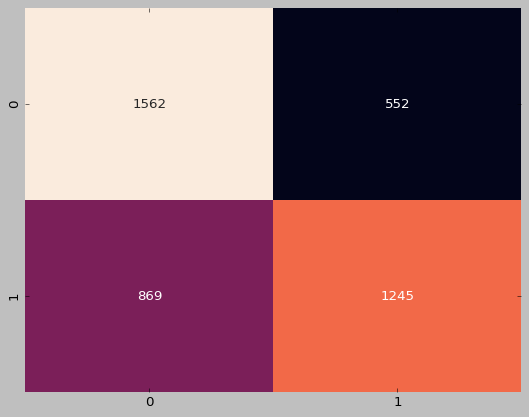

In [ ]:
best_lr = LogisticRegression(
    C=8.573575842336647e-05,
    penalty = 'l2',
    solver='saga',
    l1_ratio=None,
    max_iter=10000,
    random_state=101
)

best_lr.fit(X_train_PCA, Y_train_PCA)

Y_train_pred = best_lr.predict(X_train_PCA)
Y_test_pred = best_lr.predict(X_test_PCA)

print(classification_report(Y_train_PCA, Y_train_pred))
cm = confusion_matrix(Y_train_PCA, Y_train_pred)
sns.heatmap(cm, annot=True,fmt='d',cbar=False)

Test Results:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      2764
           1       0.48      0.59      0.53      1184

    accuracy                           0.69      3948
   macro avg       0.65      0.66      0.65      3948
weighted avg       0.71      0.69      0.70      3948



<Axes: >

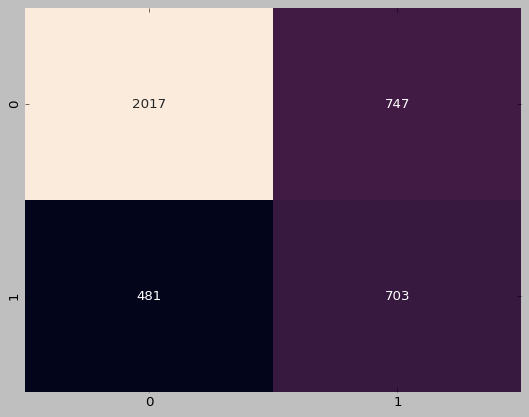

In [ ]:
print("Test Results:")
print(classification_report(Y_test, Y_test_pred))
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True,fmt='d',cbar=False) #69%, .05, PCA - 850, 59% of 1's correct: Best Hyperparameters: {'C': 1.4542761129216339e-05, 'penalty': 'l2', 'solver': 'lbfgs'}

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


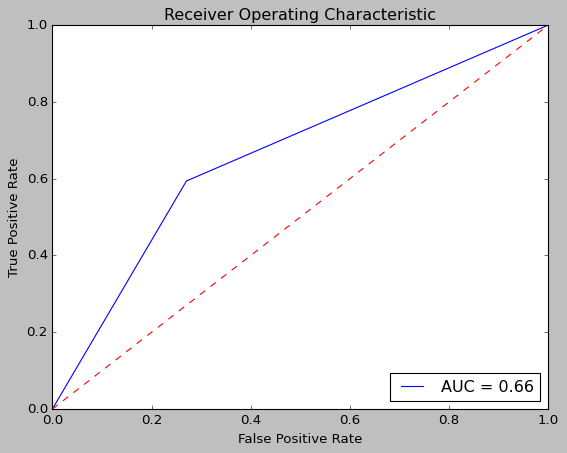

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
plt.title('Receiver Operating Characteristic')
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');
print(plt.style.available)
plt.style.use('classic')

**Tune RFC:**

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
      min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
      max_features=max_features,random_state=101, n_jobs=-1)

    score = cross_val_score(rf, X_train_PCA, Y_train_PCA, cv=3, scoring="accuracy").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best Parameters:", study.best_params)
print("Best Score:", study.best_value)

best_params = study.best_params

best_rf = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'],
                                 random_state=101)

best_rf.fit(X_train_PCA, Y_train_PCA)

Y_test_pred = best_rf.predict(X_test_PCA)
Y_train_pred = best_rf.predict(X_train_PCA)

print(classification_report(Y_train_PCA, Y_train_pred))
cm = confusion_matrix(Y_train_PCA, Y_train_pred)
sns.heatmap(cm, annot=True,fmt='d',cbar=False)

In [ ]:
print("Test Results:")
print(classification_report(Y_test, Y_test_pred))
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True,fmt='d',cbar=False)

**Tune XGB:**

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 12)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 0.3, log = True)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    #colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    #gamma = trial.suggest_float("gamma", 1e-5, 10.0, log = True))
    #reg_alpha = trial.suggest_float("reg_alpha", 1e-5, 10.0, log = True))
    #reg_lambda = trial.suggest_float("reg_lambda", 1e-5, 10.0, log = True))

    model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
        subsample=subsample,
        random_state=101, use_label_encoder=False, eval_metric="logloss")

    score = cross_val_score(model, X_train_PCA, Y_train_PCA, cv=3, scoring="accuracy").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best Hyperparameters:", study.best_params)
best_params = study.best_params

best_xgb = xgb.XGBClassifier(
    n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'], subsample=best_params['subsample'],
    random_state=101, use_label_encoder=False, eval_metric="logloss"
)

best_xgb.fit(X_train_PCA, Y_train_PCA)

Y_train_pred = best_xgb.predict(X_train_PCA)
Y_test_pred = best_xgb.predict(X_test_PCA)

print(classification_report(Y_train_PCA, Y_train_pred))
cm = confusion_matrix(Y_train_PCA, Y_train_pred)
sns.heatmap(cm, annot=True,fmt='d',cbar=False)

In [ ]:
print("Test Results:")
print(classification_report(Y_test, Y_test_pred))
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True,fmt='d',cbar=False)